In [33]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [34]:
# Parameters assumed by paper

paper_params = {
    "r": 0.05,
    "a": 0.5,
    "b": 0.05,
    "theta": 0.025,
    "sigma": 0.08,
    "lambda": -0.5,
    "gamma": 0.01,
    "h": 10,
    "mu": 0
}

t = 0
T = 20
m = 365*(T-t)
n = 1000
delta_t = (T-t)/m

In [35]:
def increment_vas(rj, t, T, m, params):
    """
    Arguments:
    rj, float: rate from time step j
    params, dict: CIR model parameters
    nj, float: jth draw from N(0,1)
    pj, float: jth draw from Poisson(h*delta_t)
    Jj, float: jth draw from N(mu, lambda)
    Returns:
    rj1, float: rate at time step j+1 
    """
    delta_t = (T-t)/m
    theta = params["theta"]
    sigma = params["sigma"]
    a = params["a"]
    lambda_ = params["lambda"]
    h = params["h"]
    gamma = params["gamma"]
    mu = params["mu"]
    
    time_step  = (theta - a*rj - lambda_*sigma)*delta_t
    stoch_step = sigma*np.random.normal()*np.sqrt(delta_t)
    jump_step  = np.random.normal(mu, gamma)*np.random.poisson(h*delta_t)
    
    rj1 = rj + time_step + stoch_step + jump_step
#     rj1 = rj + time_step + stoch_step
    return rj1

In [36]:
def increment_cir(rj, t, T, m, params):
    """
    Arguments:
    rj, float: rate from time step j
    params, dict: CIR model parameters
    nj, float: jth draw from N(0,1)
    pj, float: jth draw from Poisson(h*delta_t)
    Jj, float: jth draw from N(mu, lambda)
    Returns:
    rj1, float: rate at time step j+1 
    """
    delta_t = (T-t)/m
    theta = params["theta"]
    sigma = params["sigma"]
    a = params["a"]
    lambda_ = params["lambda"]
    h = params["h"]
    gamma = params["gamma"]
    mu = params["mu"]
    
    time_step  = (theta - a*rj - lambda_*sigma*np.sqrt(rj))*delta_t
    stoch_step = sigma*np.sqrt(rj)*np.random.normal()*np.sqrt(delta_t)
    jump_step  = np.random.normal(mu, gamma)*np.random.poisson(h*delta_t)
    
    rj1 = rj + time_step + stoch_step + jump_step
#     rj1 = rj + time_step + stoch_step
    return max(rj1, 0)

In [37]:
def simulate_path(t, T, m, model_func, params):
    """
    Arguments:
    t, float: starting time period
    T, float: maturity
    m, float: number of steps
    params, dict: model parameters
    """
    r = [params["r"]]
    ts = [t]
    h = params["h"]
    gamma = params["gamma"]
    mu = params["mu"]
    delta_t = (T-t)/m
    for j in range(m):
        r.append(model_func(r[j], t, T, m, params))
        ts.append(ts[j] + delta_t)
    prices = np.exp(-np.cumsum(np.multiply(r[1:], delta_t)))
    prices = np.insert(prices, 0, np.exp(-t*params["r"]))
    return prices, r

In [38]:
def simulate_price(t, T, m, n, model_func, params):
    """
    Arguments:
    t, float: starting time period
    T, float: maturity
    m, float: number of steps
    params, dict: model parameters
    """
    prices = np.empty((n, m+1), dtype=np.float)
    rs = np.empty((n, m+1), dtype=np.float)
    for i in range(n):
        prices[i, :], rs[i, :] = simulate_path(t, T, m, model_func, params)
    return np.mean(prices, axis=0), rs

In [39]:
def plot_price_curve(t, T, m, n, model_func, params):
    """
    Arguments:
    t, float: starting time period
    T, float: maturity
    m, float: number of steps
    params, dict: model parameters
    """
    delta_t = (T-t)/m
    Prices, rs = simulate_price(t, T, m, n, model_func, params)
    pd.Series(Prices, index=np.linspace(t, T, m+1)).plot()
    pd.DataFrame(rs.T, index=np.linspace(t, T, m+1)).plot(legend=False)
    return Prices

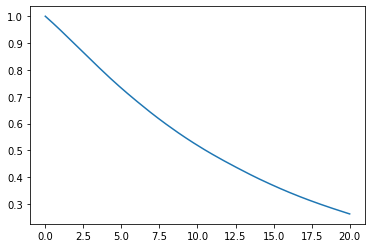

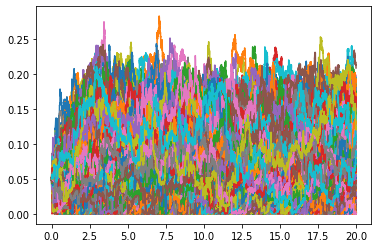

In [40]:
# np.random.seed(929469047)
Prices_cir = plot_price_curve(t, T, m, n, increment_cir, paper_params)

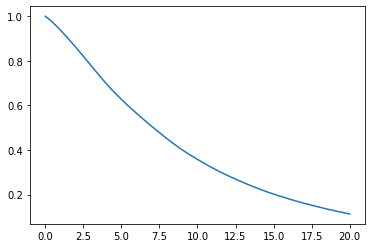

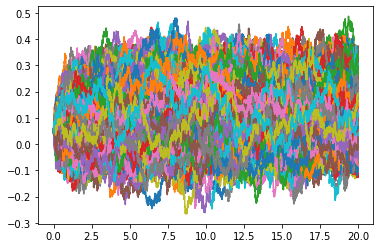

In [41]:
# np.random.seed(929469047)
Prices_vas = plot_price_curve(t, T, m, n, increment_vas, paper_params)